In [1]:
import os
from tokenize import group
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as ticker
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups

pangu_dir = r'/home1/jek/Pangu-Weather'

pres_list = np.array(['1000','925','850','700','600','500','400','300','250','200','150','100','50'])

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

steer_pres = np.array([850,700,600,500,400,300,250] )


#%%


[141.3] [27.3]


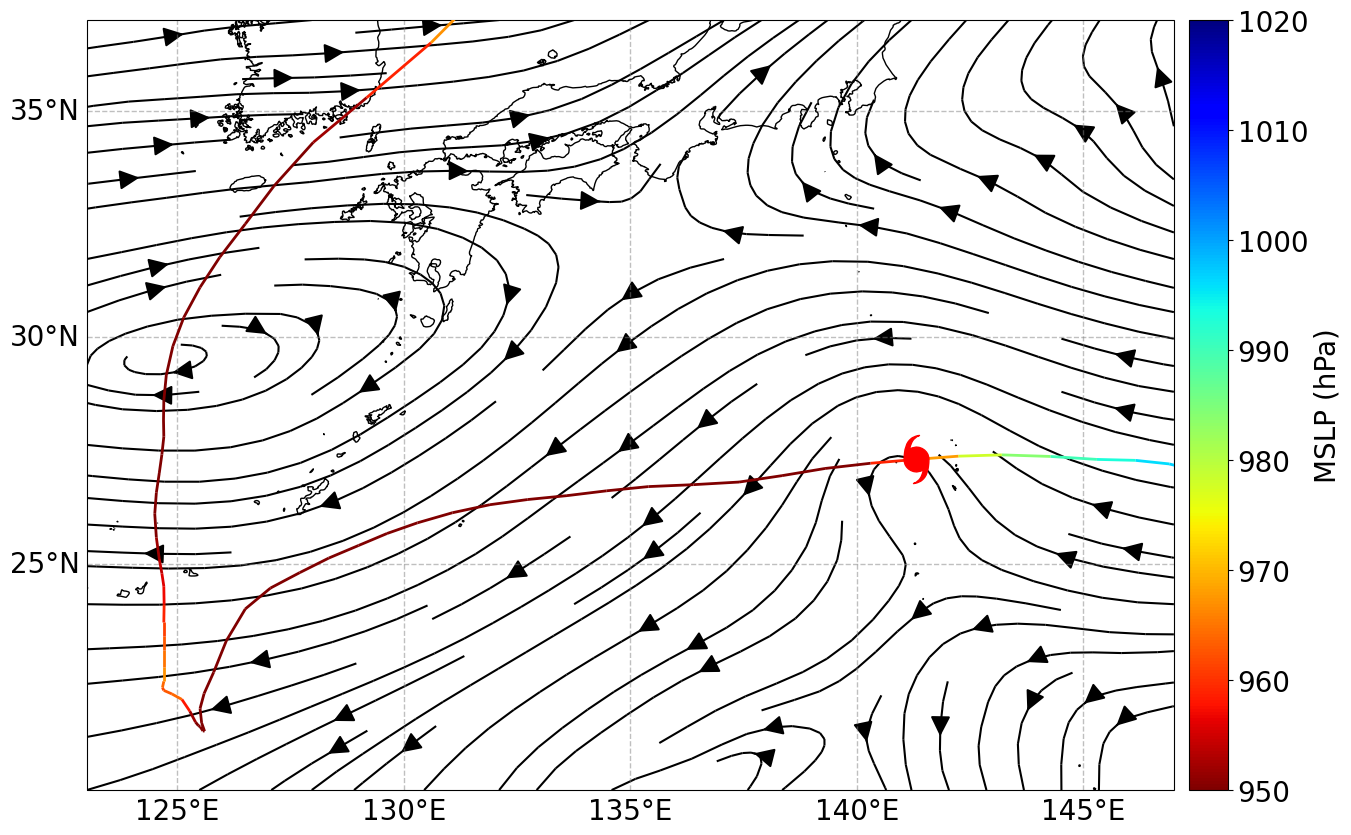

In [23]:
#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(-180,179.9,-90,90)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])
# print(lat_grid)
# lat_indices = np.linspace(-90, 90, 721)
# lon_indices = np.linspace(-180, 180, 1441)[:-1]
# lon_grid, lat_grid = np.meshgrid(lon_indices, lat_indices)
# print(lat_grid)

ssv_dict = {}


#태풍 지정
storm_name = 'Hinnamnor'                                                                               
storm_name = storm_name.upper()
storm_year = 2022

surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
perturation_scale = 0.05

#예측 시간 지정, 초기 시간 지정, 앙상블 수
# key_time_list = ['2017/07/31/00UTC','2017/08/01/00UTC','2017/08/02/00UTC']
key_time_list = ['2022/08/29/12UTC']
predict_interval_list = np.arange(0,24*7+1,24)  
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        

for first_str in key_time_list:
    first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
    key_str = first_time.strftime("%m.%d.%HUTC")
    ssv_key = first_time
    surface_factors.sort()
    upper_factors.sort()
    surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
    upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가


    datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
    # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])

    storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, wind_thres=0)   #태풍 영문명, 년도 입력

    min_position = {}  # 태풍 중심 정보 dictionary



    input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/29/12UTC'
       
    met = Met(input_data_dir, '', surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'y')

    u = met.met_data('u', level = 'all')
    v = met.met_data('v', level = 'all')
    # steer_pres를 문자열 리스트로 변환
    steer_pres = [850,700,600,500,400,300,250]
    steer_pres_str = list(map(str, steer_pres))
    # 인덱스 찾기
    indices = np.array([np.where(pres_list == p)[0][0] for p in steer_pres_str if p in pres_list])
    u = u[indices,:,:] 
    v = v[indices,:,:]

    # steer_pres 간격 계산 (앞뒤 간격 평균)
    diffs = np.diff(steer_pres)  # 각 간격 계산
    weights = np.zeros_like(steer_pres, dtype=np.float64)  # 가중치 배열 생성

    # 앞뒤 간격 평균 계산
    weights[1:-1] = (diffs[:-1] + diffs[1:]) / 2  # 중간 값은 앞뒤 간격 평균
    weights[0] = diffs[0]  # 첫 번째 값은 첫 간격 그대로
    weights[-1] = diffs[-1]  # 마지막 값은 마지막 간격 그대로

    # u, v를 steer_pres의 간격에 따라 가중 평균 (axis=1, pressure level 축)
    u_steer = np.average(u, axis=0, weights=weights)
    v_steer = np.average(v, axis=0, weights=weights)



    lat_rad = np.radians(lat_grid)
    lon_rad = np.radians(lon_grid)

    # 위도/경도 간격 (라디안 기준)
    dlat = np.gradient(lat_rad, axis=0)
    dlon = np.gradient(lon_rad, axis=1)

    # 거리 기준 간격
    R = 6.371e6  # meters
    dx = R * np.cos(lat_rad) * dlon  # (남북 간격마다 다름)
    dy = R * dlat                    # (동서 간격마다 다름)

    # 각도 → 거리로 환산하여 gradient 계산
    du_dy = np.gradient(u_steer, axis=0) / dy
    dv_dx = np.gradient(v_steer, axis=1) / dx
    vort = dv_dx - du_dy

    du_dx = np.gradient(u_steer, axis=1) / dx
    dv_dy = np.gradient(v_steer, axis=0) / dy
    div = du_dx + dv_dy
    # ty_wind = WindFieldSolver(lats, lons, TC_lat, TC_lon, vort, div)
    # ty_wind = WindFieldSolver(lat_grid, lon_grid, 25.90, 130.30, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
    ty_wind = WindFieldSolver(lat_grid, lon_grid, 22.50, 125.70, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
    u_ty, v_ty = ty_wind.solve()



    fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': ccrs.PlateCarree(180)})
    ax.set_extent([123,147,20,37], crs=proj)
    ax.streamplot(lon_grid+180, lat_grid, u_steer-u_ty, v_steer-v_ty, transform=proj, color='black', linewidth=1.5, density=1, arrowsize=3, zorder = 0)
    ax.scatter(storm_lon[storm_time == first_time]+180, storm_lat[storm_time == first_time], color='red', s=300, zorder = 10, marker = tcmarkers.HU, transform = ax.projection)
    lc = colorline(ax, storm_lon, storm_lat, z=storm_mslp, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1, transform=ax.projection)
    cbar = plt.colorbar(lc, ax=ax, orientation='vertical', label='MSLP (hPa)', shrink=1, pad = 0.01)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('MSLP (hPa)', fontsize=20)
    print(storm_lon[storm_time == first_time], storm_lat[storm_time == first_time])
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder= 0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.xlocator = ticker.FixedLocator(np.arange(-180, 180, 5))
    gl.ylocator = ticker.FixedLocator(np.arange(-90, 90, 5))
    ax.coastlines('10m')
    plt.show()

In [ ]:
#best track 그리기
storm_name = 'hinnamnor'                                                                               
storm_name = storm_name.upper()
storm_year = 2022
storm_lon, storm_lat, storm_mslp, storm_time = storm_info('/home1/jek/Pangu-Weather', storm_name, storm_year, wind_thres=0)



pangu_dir = r'/home1/jek/Pangu-Weather'

input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/29/12UTC'
pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
steer_pres = [850,700,600,500,400,300,250]
pres=500                                                #살펴볼 기압면 결정
p=pres_list.index(str(pres))
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)



#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(0,359.9,-90,90)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])

met = Met(input_data_dir, '', surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'y')

u = met.met_data('u', level = 'all')
v = met.met_data('v', level = 'all')
# steer_pres를 문자열 리스트로 변환
steer_pres_str = list(map(str, steer_pres))
# 인덱스 찾기
indices = np.array([pres_list.index(p) for p in steer_pres_str if p in pres_list])
u = u[indices,:,:] 
v = v[indices,:,:]

# steer_pres 간격 계산 (앞뒤 간격 평균)
diffs = np.diff(steer_pres)  # 각 간격 계산
weights = np.zeros_like(steer_pres, dtype=np.float64)  # 가중치 배열 생성

# 앞뒤 간격 평균 계산
weights[1:-1] = (diffs[:-1] + diffs[1:]) / 2  # 중간 값은 앞뒤 간격 평균
weights[0] = diffs[0]  # 첫 번째 값은 첫 간격 그대로
weights[-1] = diffs[-1]  # 마지막 값은 마지막 간격 그대로

# u, v를 steer_pres의 간격에 따라 가중 평균 (axis=1, pressure level 축)
u_steer = np.average(u, axis=0, weights=weights)
v_steer = np.average(v, axis=0, weights=weights)



lat_rad = np.radians(lat_grid)
lon_rad = np.radians(lon_grid)

# 위도/경도 간격 (라디안 기준)
dlat = np.gradient(lat_rad, axis=0)
dlon = np.gradient(lon_rad, axis=1)

# 거리 기준 간격
R = 6.371e6  # meters
dx = R * np.cos(lat_rad) * dlon  # (남북 간격마다 다름)
dy = R * dlat                    # (동서 간격마다 다름)

# 각도 → 거리로 환산하여 gradient 계산
du_dy = np.gradient(u_steer, axis=0) / dy
dv_dx = np.gradient(v_steer, axis=1) / dx
vort = dv_dx - du_dy

du_dx = np.gradient(u_steer, axis=1) / dx
dv_dy = np.gradient(v_steer, axis=0) / dy
div = du_dx + dv_dy
# ty_wind = WindFieldSolver(lats, lons, TC_lat, TC_lon, vort, div)
# ty_wind = WindFieldSolver(lat_grid, lon_grid, 25.90, 130.30, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
ty_wind = WindFieldSolver(lat_grid, lon_grid, 22.50, 125.70, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
u_ty, v_ty = ty_wind.solve()

#%%
#! 태풍 경로 정보 기존 정보 불러오기

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
perturation_scale = 0.05

key_time_list = ['2022/08/28/00UTC']
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,100)
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''

for first_str in key_time_list:
    first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
    key_str = first_time.strftime("%m.%d.%HUTC")
    ssv_key = first_time
    surface_factors.sort()
    upper_factors.sort()
    surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
    upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
    
    datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
    # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
    storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

    
    with open(rf'/home1/jek/Pangu-Weather/output_data/2022/08/28/00UTC/0.05ENS_z/ssv_dict_td_0_99.pkl', 'rb') as f:
        ssv_dict = pickle.load(f)

for key_time ,min_position in ssv_dict.items():
    tc_lons = {}
    tc_lats = {}
    for ens in ens_list:  
        lons = [pos['lon'] for _,pos in min_position[ens].items()]
        lats = [pos['lat'] for _,pos in min_position[ens].items()]
        min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
        pred_times = [pos for pos,_ in min_position[ens].items()]

        for i, t in enumerate(pred_times):
            if t not in tc_lons:
                tc_lons[t] = []
                tc_lats[t] = []

            tc_lons[t].append(lons[i])
            tc_lats[t].append(lats[i])

    mean_lons = []
    mean_lats = []
    for t in tc_lons:
        print(f'time: {t}, len: {len(tc_lons[t])}')
        if len(tc_lons[t]) >= 50 :
            mean_lons.append(np.mean(tc_lons[t]))
            mean_lats.append(np.mean(tc_lats[t]))
    
ax.plot(mean_lons, mean_lats, linewidth = 2, color = 'red', label = 'Pangu')
ax.plot(storm_lon, storm_lat, color = 'black', linewidth = 2, label = 'Best')
ax.streamplot(lon_grid, lat_grid, u_steer-u_ty, v_steer-v_ty, transform=proj, color='black', linewidth=1, density=1, zorder = 0)
plt.show()



(array([datetime.datetime(2022, 8, 31, 0, 0)], dtype=object), array([130.3]))

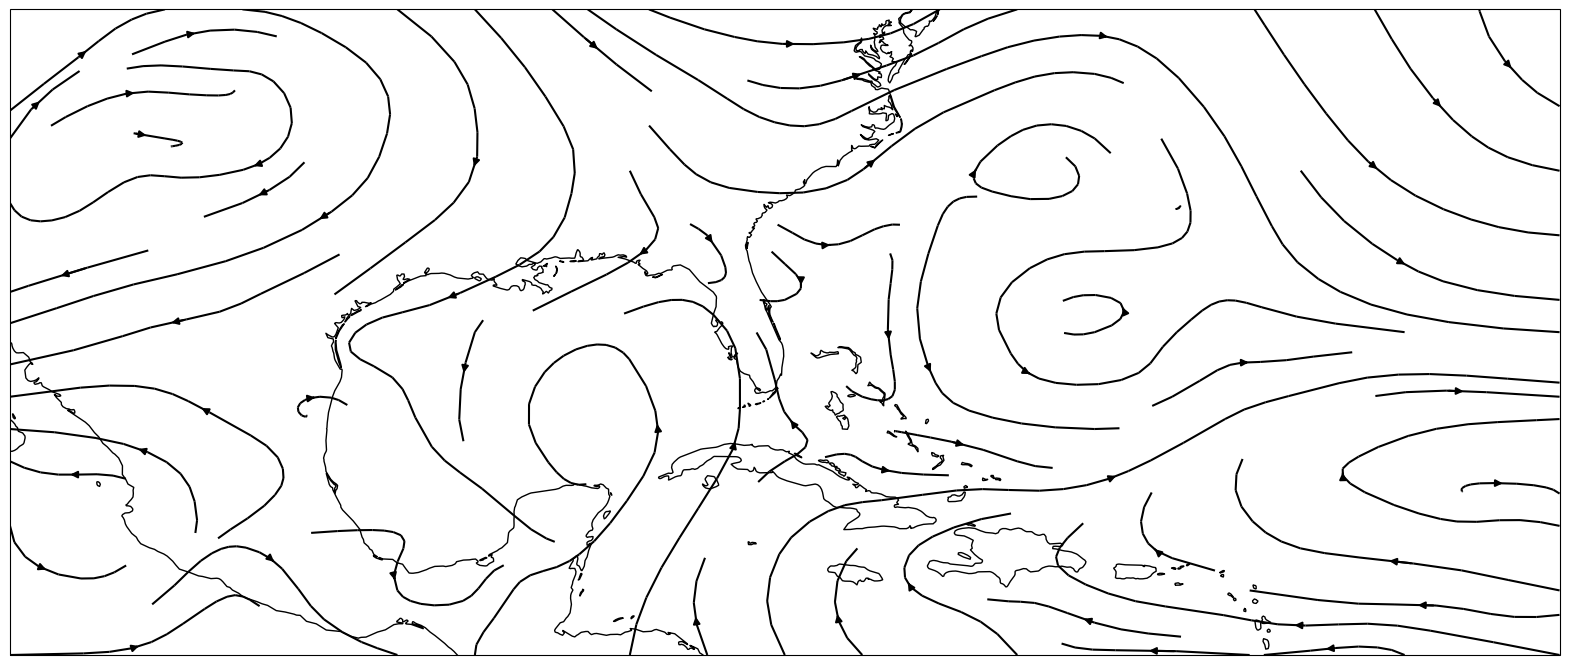

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': ccrs.PlateCarree(180)})
ax.set_extent([250,310,5,40], crs=proj)
# ax.set_extent([125,145,20,40], crs=proj)
ax.streamplot(lon_grid[::,::], lat_grid[::,::], steer_u, steer_v, color='black', density=0.7)
# cax = ax.contourf(lon_grid, lat_grid, mslp, cmap='seismic', levels=np.arange(980,1021,1), extend='both')
# cax = ax.contourf(lon_grid, lat_grid, t, cmap='seismic', levels=np.arange(270,300,1), extend='both')
# ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], steer_u[::4,::4], steer_v[::4,::4], color='black', scale=1000)
# plt.colorbar(cax)
ax.coastlines()
plt.show()

In [125]:
steer_u.shape

(7, 721, 1440)

In [41]:
np.shape(lon_grid)

(161, 241)